# ABC 

### ABC Algorithm

1. Draw θ from the prior
2. Generate the simulated data g(θ,x) = N(y, θ1x1 + θ2x2, σ^2)
3. Calculate the distance d(f(θ,x), y)
4. Accept the samples if d(f(θ,x)) < ε (threshold)

_The problem with the ABC algorithm is that a lot of samples get rejected. As the number of parameters increases, the number of accepted samples decreases. Therefore, it's necessary to reduce the number of rejected samples and make the algorithm more efficient and deterministic._

### Numpy

In [2]:
import numpy as np

In [3]:
def prior(N,dim):
    return np.random.uniform(-2,2, size=(N,dim)).astype(np.float32)


def simulator(theta, x):
    sigma = np.random.normal(0, 0.01)
    sim = np.dot(theta, x) + sigma
    return sim

def simulator2(theta, x):
    # Compute the mean of the normal distribution
    mean = np.dot(theta, x)
    # Assume fixed variance
    var = 0.01
    # Generate sample from the normal distribution with mean and variance
    sim = np.random.normal(mean, np.sqrt(var))
    return sim

def inference(y, x, theta, e):
    accepted_samples = []
    for i in range(len(theta)):
        sim = simulator2(theta[i, :], x)
        #print(sim)
        dis = np.linalg.norm(sim - y)
        #rint(dis)
        if dis < e:
            accepted_samples.append(theta[i,:])
    return np.array(accepted_samples)


# Define the dimensions and the number of samples
N = 100000
dim = 10 # 2, 5, 10

# Observation
y_obs = np.array(0.3)
# Use seed to have the same value for x in each run
np.random.seed(42)
x = np.random.uniform(-0.5, 0.5, size=(dim,))
#print(x)
e = 0.01 # threshold

# Sampling thetas
np.random.seed(None)
theta_pr =prior(N, dim)

# List of the accepted samples
samples_pos = inference(y_obs, x, theta_pr, e)

In [9]:
samples_pos.shape # simulator1: 2: 1167, 5: 981, 10: 669, simulator2: 2: 1097:931, 10:642

(642, 10)

## Sequential Monte Carlo (SMC)

The main idea of SMC is to approximate a target distribution, such as a posterior $P(\theta|y)$, by representing it with a set of particles and associate weights. These particles are drawn from a sequence of intermediate distributions that gradually move closer to the target. The process allow us to gradually "home in" on the posterior, making it easier to explore complex or high-dimension parameter spaces.

**Basic SMC Algorithm Steps.**

**Step 1: Initialization**
- Draw particles ${\theta^{(i)}_0}_{i=1}^N$ from the prior distribution $P(\theta)$. Here, N is the number of particles.
- Assign initial weights $ w_0^{(i)} = \frac{1}{N}$, giving each particle an equal weight initially.

**Step 2: Importance Weighting**
- As new information (e.g., observations or likelihood updates) is incorporated, update the weights of each particle to reflect how well each particle $\theta^{(i)}$ fits the observed data.
- The updated weight is given by:

$$
w^{(i)}_t = w^{(i)}_{t-1} \cdot \frac{\pi_t(\theta^{(i)})}{\pi_{t-1}(\theta^{(i)})}
$$

- This updated depends on the ratio of the current distribution $\pi_t$ to the previous distribution $\pi_{t-1}$. The updated weights emphasize particles that align better with the target distribution.

**Step 3: Resampling**
- As iterations progress, some particles will have much higher weights than others, leading to particle degnerancy (i.e., only a few particles dominate).
- To counter this, resample the particles based on their weights. This step selects particles with higher weights more frequently, creating a new set of particles $\theta^{(i)}$ with equal weights but reflecting the structure of the target distribution.

**Step 4: Mutation (or Perturbation)**
- After resampling, particles might need to be moved slightly to explore the parameter space effectively.
- Add random noise (e.g., from a Gaussian distribution) to each particle to introduce diversity and prevent the algorithm from converging prematurely. This step allows for exploring the target distribution more broadly.

**Step 5: Repeat for Each Intermediate Distribution**
- Repeat steps 2-4, iterating through the sequence of intermediate distributions until reaching final target distribution. Each iteration helps improve the approximation by gradually focusing the high-probability regions of the posterior distribution.

**Step 6: Final Approximation**
- At the latest step $T$, the set of particles and their weghts represent the final approximation of the target posterior distribution $P(\theta|y)$.


In [20]:
import numpy as np
from scipy.stats import norm

# Parameters 
N = 100000  # Number of particles
d = 2  # Dimension of theta
y_obs = 0.3  # Observation
tolerance_seq = [0.1, 0.05, 0.01]  # Sequence of tolerance values for ABC

# Step 1: Initialize particles from uniform prior
def prior(N, dim):
    return np.random.uniform(-2, 2, size=(N, dim))

# Define the simulator function
def simulator2(theta, x):
    # Compute the mean of the normal distribution
    mean = np.dot(theta, x)
    # Assume fixed variance
    var = 0.01
    # Generate sample from the normal distribution with mean and variance
    sim = np.random.normal(mean, np.sqrt(var))
    return sim


# Inference function for resampling and weight updating 
def inference(particles, weights, epsilon,x, y_obs):
    # Step 2: compute distances and update weights
    distances = []
    for i, theta in enumerate(particles):
        simulated_data = simulator2(theta, x) # Simulate data based on theta
        distance = abs(simulated_data - y_obs) # Distance between simulate and observed data
        distances.append(distance)

    distances = np.array(distances)
    print(f"Distances: {distances[:10]}") # Print the first 10 distances for insepction

    # Accept indices based on the tolerance criterion
    accepted_indices = np.where(distances <= epsilon)[0]

    # Check if we have enough particles that meet the tolerance criterion
    if len(accepted_indices) == 0:
        print("No particles met the tolerance criteria.")
        return particles, weights, 0 # No particles to return 

    # Step 3: Resample particles based on weights with tolerance, update the weights at the accepted_indices
    weights[accepted_indices] = 1 / len(accepted_indices) # Equal weight for accepted particles

    # Resample the particles based on the updated weights
    resample_indices = np.random.choice(accepted_indices, N, p=weights[accepted_indices] / np.sum(weights[accepted_indices]))
    particles = particles[resample_indices]

    # Step 4: Mutate particles (add small Gaussian noise)
    mutation_std = 0.1 # Standard deviation for mutation step
    particles += np.random.normal(0, mutation_std, size=particles.shape)

    # Normalize weights: After resampling the weights should have the uniform weights.
    # Treat each of the particles as equally important for the next iteration
    weights.fill(1 / N)

    return particles, weights, len(accepted_indices)

# Main execution of the ABC-SMC Algorithm
def smc_algorithm():
    # Initialize particles and weights
    particles = prior(N, d)
    weights = np.ones(N) / N # Start with equal weights

    np.random.seed(42)
    x = np.random.uniform(-0.5, 0.5, size=(d,))
    print(f"Observation: {y_obs}")
    print(f"X: {x}")

    # ABC - SMC Algorithm
    for epsilon in tolerance_seq:
        print(f"\nTolerane: {epsilon}")

        # Call the inference function to handle resampling and mutation
        particles, weights, num_accepted = inference(particles, weights, epsilon, x, y_obs)

        # Print diagnostics
        print(f"Number of accepted particles: {num_accepted}")
        print(f"Mean of particles: {particles.mean(axis=0)}")

        # If no particles met the tolerance criteria, break out of the loop
        if num_accepted == 0:
            break

    # Final posterior approximation 
    print(f"\nFinal posterior approximation:")
    print(f"Mean of particles: {particles.mean(axis=0)}")
    print(f"Std of particles: {particles.std(axis=0)}")

# Run the SMC algorithm
smc_algorithm()

Observation: 0.3
X: [-0.12545988  0.45071431]

Tolerane: 0.1
Distances: [0.18312154 0.09971538 0.85532105 0.20283967 0.74551784 0.00200507
 0.16128344 0.03817878 0.08106506 0.6599993 ]
Number of accepted particles: 11284
Mean of particles: [-0.0172179   0.66043963]

Tolerane: 0.05
Distances: [0.08481815 0.05848579 0.23746552 0.09203515 0.12617617 0.02896113
 0.26576308 0.07038863 0.03595862 0.29223015]
Number of accepted particles: 24675
Mean of particles: [-0.00351892  0.66668099]

Tolerane: 0.01
Distances: [0.01352649 0.25886204 0.07567476 0.08461975 0.03292694 0.01452921
 0.02903176 0.15126857 0.02659409 0.29426263]
Number of accepted particles: 5919
Mean of particles: [0.01872154 0.67357887]

Final posterior approximation:
Mean of particles: [0.01872154 0.67357887]
Std of particles: [1.17631693 0.37184215]


## SMC example 2

(100,)
The first 5 data are: [2.52151523 2.38606711 1.45833602 2.02750714 1.90296065]
(1000,)
Step 0: Estimated mean = 1.216391559690648
Step 10: Estimated mean = 1.8785413627289511
Step 20: Estimated mean = 2.143299246931742
Step 30: Estimated mean = 1.9011318103271153
Step 40: Estimated mean = 2.0213070890340554
Step 50: Estimated mean = 1.9854163325220482
Step 60: Estimated mean = 2.001195769486262
Step 70: Estimated mean = 2.105943247881935
Step 80: Estimated mean = 2.071936734247056
Step 90: Estimated mean = 2.233975147063562
Final estimate of the mean: 2.169785156397874


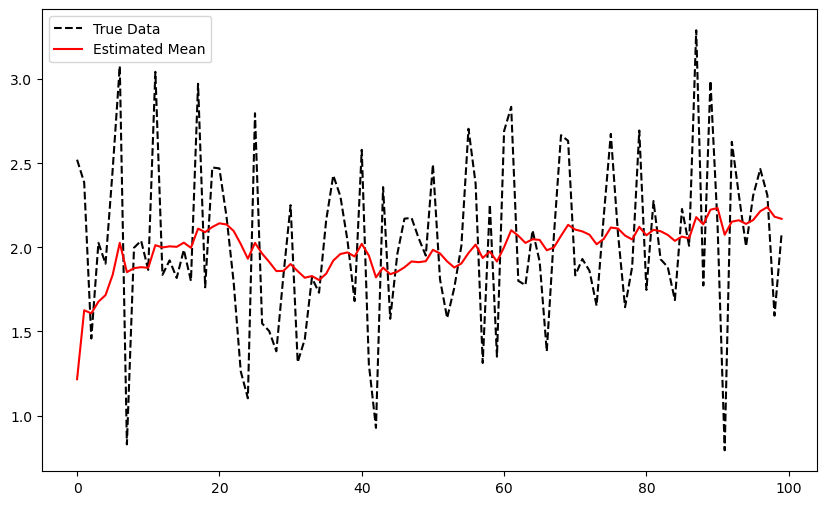

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Parametes
N = 1000
d = 1
T = 100 # number of time steps

# True model parameters
true_mean = 2.0
true_std = 0.5

# Generate true data (for testing)
true_data = true_mean + true_std*np.random.randn(T)
print(true_data.shape)
print(f"The first 5 data are: {true_data[:5]}")

# Initializing particles(from prior distribution)
def initialize_particles(N,d):
    return np.random.randn(N,d) # Assuming a standard normal distribution as prior belief

# Define the model dynamics (transition function)
def transition_function(particles):
    return particles + 0.1*np.random.randn(*particles.shape) # Add noise to particles

# Define the likelihood function
def likelihood(particles, observation):
    return np.exp(-0.5*((particles-observation)**2)).flatten() # Gaussian likelihood

# Resample particles based on weights
def resample(particles, weights):
    indices = np.random.choice(np.arange(N), size=N, p=weights/weights.sum())
    return particles[indices]

# Main SMC algorithm
def smc_algorithm():
    # Initialize particles
    particles = initialize_particles(N,d)
    weights = np.ones(N)/N
    
    # List to store estimates of the mean for each time step
    estimates = []

    for t in range(T):
        # Step 1: Prediction (Apply transition function)
        particles = transition_function(particles)
        
        # Step 2: Compute weights (based on the likelihood of observed data)
        observation = true_data[t] # Assume we have true observed data
        weights = likelihood(particles, observation)
        #print(weights.shape)

        # Normalize weights
        weights /= np.sum(weights)

        # Step 3: Resample particles based on their weights
        particles = resample(particles, weights)

        # Step 4: Mutation step (add gaussian noise to prevent particle degeneracy)
        particles += 0.05*np.random.randn(N,d)

        # Compute the mean estimate of the particles
        mean_estimate = np.mean(particles)
        estimates.append(mean_estimate)

        # Optionally print some diagnostics
        if t % 10 == 0:
            print(f"Step {t}: Estimated mean = {mean_estimate}")

    # Final estimate of the posterior
    final_estimate = np.mean(particles)
    print(f"Final estimate of the mean: {final_estimate}")

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(true_data, label="True Data", color='k', linestyle='--')
    plt.plot(estimates, label="Estimated Mean", color='r')
    plt.legend()
    plt.show()

# Run the smc algorithm
smc_algorithm()

    


## OMC

### OMC algorithm

1. Draw θ from the prior
2. Draw u (nuisance variables) from its distribution
3. Generate the simulated data ysim = f(θ x u)
4. Define the objective function d(f(θ,u), y))
5. Minimize the objective function to find the optimal u, u*
6. Find the new simulated data based on u*
7. Compute the jacobian matrix J $ \frac{\partial f(\theta, u)}{\partial \theta} $
8. Compute the weights from the formula $ w_i = \left(\det(J^\top J)\right)^{-\frac{1}{2}} $
9. Accept $ \theta_i $ as posterior sample with weight $ w_i $.

In the final posterioro distribution each sample $\theta$ has a weight that clarifies how well this sample is related to the observed data. The weighted mean of the posterior distribution comes from the below formula:

$$
\mu_{\text{weighted}} = \frac{\sum_{i=1}^N w_i \cdot \theta_i}{\sum_{i=1}^N w_i}
$$

This weighted mean represents the expected value of the posterior distribution, where each sample $\theta_i$ is scaled by its respective weight $w_i$, making the calculation sensitive to how well each sample aligns with the observed data.


_The determinant of the Jacobian matrix represents the volume of the parallepepiped spanned by the columns of $ J_i $. This volume gives insights in how changes in $ \theta $ affect the summary statistics. Ill-conditioned matrices $  J_i^\top J_i $ produce very large weights for the corresponding $ \theta_i $, possibly completely overshadowing the remaining samples and creating an approximate posterior density that is spiked at a single location. These ill-conditioned matrices occur when a large parameter region around the optimum $ \theta_i $ produces data with small distances. In other words, the OMC failure occurs when a large parameter region around $ \theta_i $ is a solution to $ || f(\theta, u) - y|| < \epsilon $, meaning different $ \theta $ generate the same $ y $, which happens for example, when the likelihood function is (nearly) constant around $ \theta_i $._

In [15]:
import numpy as np
from scipy.optimize import minimize

def prior(N, dim):
    return np.random.uniform(-2, 2, size=(N, dim)).astype(np.float32)

def simulator(theta, u):
    # Assuming the simulator function is linear in theta and u introduces stochasticity
    return np.dot(theta, u)

def objective_function(u, theta, y):
    sim = simulator(theta, u)
    return np.linalg.norm(sim - y)

def compute_jacobian(theta, u):
    # Jacobian of the simulator with respect to theta
    return np.array([u] * len(theta))

def compute_weight(jacobian_matrix, regularization=1e-8):
    #JTJ = np.dot(jacobian_matrix.T, jacobian_matrix) + np.eye(jacobian_matrix.shape[1]) * regularization
    JTJ = np.dot(jacobian_matrix.T, jacobian_matrix)
    det = np.linalg.det(JTJ)
    return (1.0 / np.sqrt(det)) if det > 0 else 0

def inference(y, theta, u_dim):
    accepted_samples = []
    weights = []
    
    for theta_i in theta:
        #print(f'Theta_i is: {theta_i}')
        
        # Initial guess for u (can be sampled from a distribution)
        u_init = np.random.uniform(-1, 1, u_dim)
        #print(f'U_init is: {u_init}')
        result = minimize(objective_function, u_init, args=(theta_i, y), method='L-BFGS-B')
        u_star = result.x
        #print(f'u_star is {u_star}')
        
        sim = simulator(theta_i, u_star)
        jacobian_matrix = compute_jacobian(theta_i, u_star)
        weight = compute_weight(jacobian_matrix)
        
        accepted_samples.append(theta_i)
        weights.append(weight)
    
    return np.array(accepted_samples), np.array(weights)

# Define the dimensions and the number of samples
N = 1000
theta_dim, u_dim = 5, 5  # Dimension of theta, # Dimension of nuisance variables

# Observation
y_obs = np.full(theta_dim, 0.3)  # Assuming y has the same dimension as simulator output
np.random.seed(42)

# Sampling thetas
np.random.seed(None)
theta_pr = prior(N, theta_dim)

# List of the accepted samples
samples_pos, weights = inference(y_obs, theta_pr, u_dim)
print(f'Number of accepted samples: {len(samples_pos)}')

# Weighted mean for each dimension of theta
weighted_mean = np.average(samples_pos, weights = weights, axis=0)
# Weighted variance for each diemension of theta
weighted_variance = np.average((samples_pos - weighted_mean)**2, weights = weights, axis=0)
weighted_std = np.sqrt(weighted_variance)

print(f"The mean value of the weighted posterior distributioin is: {weighted_mean}")
print(f"The standard deviation of the weighted posterior distribution is: {weighted_std}")

Number of accepted samples: 1000
The mean value of the weighted posterior distributioin is: [-1.86179057 -1.23645876 -1.26782772  1.8164966   0.13166435]
The standard deviation of the weighted posterior distribution is: [0.07521138 0.04161248 0.0480585  0.05142853 0.03505477]


In [16]:
# Create a mask for non-zero weights
non_zero_mask = weights > 0

# Apply the mask to filter samples and weights
filtered_samples = samples_pos[non_zero_mask]
filtered_weights = weights[non_zero_mask]

print(f'The number of the non-negative samples are: {len(filtered_samples)}')

The number of the non-negative samples are: 388


In [20]:
print(f"The mean value of the non-zero samples is: {filtered_samples.mean(axis=0)}")

The mean value of the non-zero samples is: [-0.13661782 -0.07151812  0.0107074   0.03357551  0.00930376]
